Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Оглавление
1. [Подготовка](#One)
2. [Обучение](#Two)
3. [Проверка на адекватность](#Three)
4. [Выводы](#Four)

# 1. Подготовка <a class="anchor" id="One"></a>

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import pymorphy2
import itertools  
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import WhitespaceTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
count_vect = CountVectorizer()

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
#from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel

In [ ]:
import numpy as np
import torch
import gc
import tqdm
from tqdm import notebook
import time

In [ ]:
from nltk.corpus import stopwords as stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [ ]:
%%bash
pip -q install transformers

In [ ]:
import sys
import codecs
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel, BertForMaskedLM

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
#Для уменьшения объема используемой памяти приведем целевой признак к типу int8
data['toxic'] = data['toxic'].astype('int8')

In [ ]:
#Приведем текст датасета к нижнему регистру
data['text'] = data['text'].apply(lambda x: x.lower())

У нас неочищенные английские тексты. Так же есть дисбаланс классов.


In [ ]:
def clear_text(text):    
    text_cl = re.sub(r'[^a-zA-Z ]', ' ', text) 
    return " ".join(text_cl.split())

In [ ]:
# лемматизатор на pymystem3, не всегда приводит английские слова к леммам
m = Mystem()

# лемматизатор на pymorphy2, принимает на вход строки
morph = pymorphy2.MorphAnalyzer()

# лемматизатор NLTK , принимает на вход слова
lemmatizer = WordNetLemmatizer()


def lemmatizer_m(text):
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
    return lemm_text

def lemmatizer_morf(text):
    lemm_list = morph.parse(text)[0].normal_form
    lemm_text = "".join(lemm_list)               
    return lemm_text

def lemmatizer_nltk(text): 
    w_tokenizer = WhitespaceTokenizer()
    lemm_list = [lemmatizer.lemmatize(i) for i  in w_tokenizer.tokenize(text)]
    lemm_text = " ".join(lemm_list)
    return lemm_text



In [ ]:

corpus = list(data['text'])
display("Исходный текст:", corpus[0])
display("Очищенный текст:", clear_text(corpus[0]))
display("Лемматизированный текст m:", lemmatizer_m(clear_text(corpus[0])))
display("Лемматизированный текст morf:", lemmatizer_morf(clear_text(corpus[0])))
display("Лемматизированный текст nltk:", lemmatizer_nltk(clear_text(corpus[0])))

'Исходный текст:'

"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

'Очищенный текст:'

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now'

'Лемматизированный текст m:'

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now\n'

'Лемматизированный текст morf:'

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now'

'Лемматизированный текст nltk:'

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalism just closure on some gas after i voted at new york doll fac and please don t remove the template from the talk page since i m retired now'

In [ ]:
%%time
start_time = time.time()
data['clear'] = data['text'].apply(clear_text)
clear_time = time.time() - start_time

CPU times: user 2.74 s, sys: 57.2 ms, total: 2.8 s
Wall time: 2.81 s


In [ ]:
%%time
start_time = time.time()
# применим лемматизатор NLTK, т.к. он чуть лучше работает и обрабатывет мн. число
data['lemmatize'] = data['clear'].apply(lemmatizer_nltk)
lemmatize_time = time.time() - start_time

CPU times: user 60 s, sys: 315 ms, total: 1min
Wall time: 1min 1s


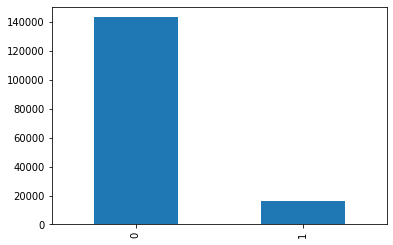

In [ ]:
data['toxic'].value_counts().plot(kind='bar')

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера</b>

Молодец, что оценил дисбаланс классов. Было бы здорово также подписать график.

</div>


Итак в целевом признаке всего два класса, это задача бинарной классификации. Токсичных комментариев в выборке мало - всего 10% (имеет место дисбаланс классов). Убрать дисбаланс можно несколькими способами: 
  - провести апсемплинг выборки.
  - провести даунсемплинг выборки. 
 

# 2. Обучение <a class="anchor" id="Two"></a>

In [ ]:
# Разделим признаки на обучающий и целевой. 

features = data['lemmatize']
target = data['toxic']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [ ]:
# Для борьбы с дисбалансом классов проведем апсемплинг
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [ ]:
# Токсичных комментариев примерно в 9 раз меньше
# x_train, y_train = upsample(x_train, y_train, 9)
# не применяем т.к. в юпитере kernel падает

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled.reset_index(drop=True), target_downsampled.reset_index(drop=True)

In [ ]:
#x_train, y_train = downsample(x_train, y_train, 0.1)
# не применяем т.к. значения метрики получились ниже

In [ ]:
corpus_x_train = x_train.values.astype('U')
corpus_x_test = x_test.values.astype('U')

Далее вычислим TF-IDF для полученных текстов. Стоп-слова оставил, т.к. без них метрика ниже.

In [ ]:
count_vector = TfidfVectorizer()
bow_X_train = count_vector.fit_transform(corpus_x_train)#.toarray()
bow_X_test = count_vector.transform(corpus_x_test)#.toarray()

In [ ]:
del x_train
del x_test
x_train = bow_X_train
x_test = bow_X_test
x_test

<47872x128702 sparse matrix of type '<class 'numpy.float64'>'
	with 1968509 stored elements in Compressed Sparse Row format>

### LogisticRegression

In [ ]:
%%time
start_time = time.time()

model_logreg = LogisticRegression(solver='lbfgs', max_iter=200)

# Значения метрики на кросс валидации
lr_cv_f1 = (cross_val_score(model_logreg, 
                             x_train, 
                             y_train, 
                             cv=5, 
                             n_jobs=-1,
                             scoring='f1').mean())
print('Логистическая регрессия')
print('Значение F1 по результатам кросс-валидации на train =', lr_cv_f1)

lr_cv_time = time.time() - start_time

Логистическая регрессия
Значение F1 по результатам кросс-валидации на train = 0.7191454040552734
CPU times: user 2min 12s, sys: 2min 14s, total: 4min 27s
Wall time: 4min 28s


In [ ]:
%%time
start_time = time.time()

model_logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=12345, n_jobs=-1, max_iter=200)
model_logreg.fit(x_train, y_train)
y_pred = model_logreg.predict(x_test)
lr_f1 = f1_score(y_test, y_pred)
print('Логистическая регрессия')
print('Значение F1 на test =', lr_f1)

lr_time = time.time() - start_time

Логистическая регрессия
Значение F1 на test = 0.7526995928482918
CPU times: user 31.1 s, sys: 25.7 s, total: 56.8 s
Wall time: 57.2 s


In [ ]:
lr_cv_f1 = 0.7191454
lr_cv_time = 268
lr_f1 = 0.7526995
lr_time = 57.2

### RandomForestClassifier

In [ ]:
%%time
start_time = time.time()

rf_model = RandomForestClassifier(n_jobs=-1, random_state = 12345)
    
hyperparams = {'n_estimators': [100,150],
                  'max_depth': [100,200],
              #'max_features': ['auto'],
             #'criterion' :['gini', 'entropy'],
                  }

rf_grid = GridSearchCV(rf_model, hyperparams, scoring='f1', cv=5)

rf_grid.fit(x_train, y_train)
rf_cv_f1 = rf_grid.best_score_

print('Лучшее значение F1 по результатам кросс-валидации на train =', rf_cv_f1)
print('Лучшие гиперпараметры:', rf_grid.best_params_)

rf_cv_time = time.time() - start_time # Записываем время работы ячейки 

In [ ]:
%%time
start_time = time.time()

rf_model = RandomForestClassifier( max_depth=200, n_estimators=150, n_jobs=-1, random_state = 12345)
# Модель на тестовой выборке

rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
rf_f1 = f1_score(y_test, y_pred)
print('Случайный лес')
print('Значение F1 на test=' , rf_f1)

rf_time = time.time() - start_time # Записываем время работы ячейки 

Случайный лес
Значение F1 на test= 0.4956214472269166
CPU times: user 7min 56s, sys: 304 ms, total: 7min 56s
Wall time: 8min 11s


In [ ]:
# При запуске кросс-валидации RandomForestClassifier в юпритере kernel падает, взял данные при запуске в Colab
rf_cv_f1 = 0.45034
rf_cv_time = 7216
rf_f1 = 0.4956214
rf_time = 491

### LightGBM

In [ ]:
%%time
start_time = time.time()

from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

model_lgbm = lgb.LGBMClassifier()

hyperparams = {'num_leaves'   : [30, 40],
              'learning_rate' : [0.1, 0.5],
              'n_estimators'  : [200,400]}

grid = GridSearchCV(model_lgbm, hyperparams, cv = 5, n_jobs=-1, scoring='f1')
grid.fit(x_train, y_train)
lgbm_cv_f1 = grid.best_score_

print('Лучшее значение F1 по результатам кросс-валидации на train =', lgbm_cv_f1)
print('Лучшие гиперпараметры:', grid.best_params_)

lgbm_cv_time = time.time() - start_time

In [ ]:
%%time
start_time = time.time()

#Обучаем модель LightGBM
model_lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1)
model_lgbm.fit(x_train, y_train)

#Предсказываем и замеряем (LightGBM)
pred_test = model_lgbm.predict(x_test)
lgbm_f1 = f1_score(y_test, pred_test)
print('LightGBM')
print("F1 тестовой выборки =", lgbm_f1)
print()

lgbm_time = time.time() - start_time

In [ ]:
# При запуске LightGBM в юпритере kernel падает, взял данные при запуске в Colab
lgbm_cv_f1 = 0.7838547
lgbm_cv_time = 6582
lgbm_f1 = 0.785237
lgbm_time = 159

### XGBClassifier

In [ ]:
%%time
start_time = time.time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgb_model = xgb.XGBClassifier(random_state = 12345)

hyperparams = { 'max_depth': [50, 70, 80],
                'n_estimators': [25,35,45]}

grid_xgbst = GridSearchCV(xgb_model, hyperparams, scoring='f1', cv=5, n_iter=10, n_jobs=1)

model_xgboost = grid_xgbst.fit(x_train, y_train)
xgbc_cv_f1 = grid_xgbst.mean()

print('Лучшие гиперпараметры:', grid_xgbst.best_params_)
print()
print('Значение F1 по результатам кросс-валидации на train =', xgbc_cv_f1)

xgboost_cv_time = time.time() - start_time # Записываем время работы ячейки

In [ ]:
%%time
start_time = time.time()

model_XGBC = xgb.XGBClassifier(max_depth = 70, n_estimators = 35, n_jobs=-1, random_state = 12345)
model_XGBC.fit(x_train, y_train)
predict_XGBC = model_XGBC.predict(x_test)
xgbc_f1 = f1_score(y_test, predict_XGBC)
print('Значение F1 на test=' , xgbc_f1)

xgboost_time = time.time() - start_time

In [ ]:
# При запуске XGBClassifier в юпритере kernel падает, взял данные при запуске в Colab

xgboost_cv_f1 = 0.7109
xgboost_cv_time =  8273
xgboost_f1 = 0.7140394
xgboost_time = 493.336

## LogisticRegression_Bert

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')
model.config

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Для ускорения обработки возьмем выборку из 20000 строк
data = data.sample(20000)

В датасете имеются очень длинные токены, модель BERT требует использовать токены менее длиной менее 512. Исключим из датасета длинные токены.

In [ ]:
tokenized = data['clear'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
max_len

In [ ]:
target = data['toxic']
del data

In [ ]:
target.value_counts()

In [ ]:
# Выборка несбалансированная, проведем даунсемплинг.
tokenized_down, target_down = downsample(tokenized, target, 0.1)

In [ ]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized_down.values])
padded.shape

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
gc.collect() # Сборщик мусора

In [ ]:
# Создадим эмбеддинги
batch_size = 20
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // (batch_size))):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
# 100%  189/189 [1:51:02<00:00, 35.25s/it]

 - Время работы эмбединга составило 1 час 51 минута

In [ ]:
# Удалим ненужные более массивы и запустим сборщик мусора
del padded, attention_mask
gc.collect()

In [ ]:
# Выделим признаки
features_bert = np.concatenate(embeddings)

In [ ]:
features_bert.shape

In [ ]:
target_down.shape

In [ ]:
# Размер матрицы признаков и матрицы целевого признака отличаются из-за специфики проведения эмбеддинга, исключим из матрицы целевого признака лишние значения
index = list(range(0, features_bert.shape[0]))

In [ ]:
target_down = target_down[index]

In [ ]:
target_down.shape

In [ ]:
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(features_bert, target_down, test_size=0.3, random_state=12345)

In [ ]:
%%time
start_time = time.time()

model_logreg = LogisticRegression()

# Значения метрики на кросс валидации
lr_b_cv_f1 = (cross_val_score(model_logreg, 
                             x_train_b, 
                             y_train_b, 
                             cv=5, 
                             n_jobs=-1,
                             scoring='f1').mean())
print('Логистическая регрессия BERT')
print('Значение F1 по результатам кросс-валидации на train =', lr_b_cv_f1)

lr_cv_bert_time = time.time() - start_time


#Логистическая регрессия BERT
#Значение F1 по результатам кросс-валидации на train = 0.8799075363514733
#CPU times: user 34 ms, sys: 7.01 ms, total: 41 ms
#Wall time: 1.35 s

In [ ]:
%%time
start_time = time.time()

model_logreg = LogisticRegression(class_weight='balanced', random_state=12345, n_jobs=-1, max_iter=100)
model_logreg.fit(x_train_b, y_train_b)
y_pred = model_logreg.predict(x_test_b)
lr_b_f1 = f1_score(y_test_b, y_pred)
print('Логистическая регрессия BERT')
print('Значение F1 на test =', lr_b_f1)

lr_bert_time = time.time() - start_time

#Логистическая регрессия BERT
#Значение F1 на test = 0.8823016564952048
#CPU times: user 21.3 ms, sys: 13 ms, total: 34.3 ms
#Wall time: 4.31 s

In [ ]:
# В Юпитере кернел опять упал. Запускал код в Colab
lr_cv_bert_f1 = 0.8799
lr_cv_bert_time = 1.35
lr_bert_f1 = 0.8823
lr_bert_time = 4.31

# 3. Проверка на адекватность <a class="anchor" id="Three"></a>

In [ ]:
from sklearn.dummy import DummyClassifier
model_dummy = DummyClassifier()

In [ ]:
model_dummy.fit(x_train, y_train)
prediction_dummy = model_dummy.predict(x_test)
print('f1_score для Dummy модели составил ', f1_score(y_test, prediction_dummy))

f1_score для Dummy модели составил  0.09923741738688358


- F1 константной модели почти равна 0. Это говорит, что выбранная модель адекватна

# 4. Выводы <a class="anchor" id="Four"></a>

In [ ]:
# Записываем результаты в словарь
dict_results = {'Model': ['LogisticRegression,' , 'Random_Forest' , 'LightGBM' ,'XGBoost', 'LogisticRegression_Bert'],
               'F1_CV':[lr_cv_f1 , rf_cv_f1 , lgbm_cv_f1 , xgboost_cv_f1, lr_cv_bert_f1] ,
               'F1_test': [lr_f1 , rf_f1 , lgbm_f1 , xgboost_f1, lr_bert_f1] , 
               'Working_time_CV' : [lr_cv_time , rf_cv_time , lgbm_cv_time , xgboost_cv_time, lr_cv_bert_time ],
               'Working_time_test': [lr_time , rf_time , lgbm_time , xgboost_time, lr_bert_time ]
               } 
Results = pd.DataFrame(dict_results)
Results

,Model,F1_CV,F1_test,Working_time_CV,Working_time_test
0,"LogisticRegression,",0.719145,0.752699,268.00,57.200
1,Random_Forest,0.450340,0.495621,7216.00,491.000
2,LightGBM,0.783855,0.785237,6582.00,159.000
3,XGBoost,0.710900,0.714039,8273.00,493.336
4,LogisticRegression_Bert,0.879900,0.882300,1.35,4.310


Как видим из таблицы лучшая метрика и время выполнения у модели LogisticRegression с BERT. Правда нужно учесть, что на создание эмбеддинга ушло 1ч.51мин. Но даже учитывая это, общее время обучения меньше, чем у RandomForestClassifier, LightGBM и XGBClassifier

## Общий вывод

1. Загрузил бибилиотки для обучения и подготовки данных
2. Ипользование лемматизации и TF-IDF
   - Выполнил чистку данных и приведение к нижнему регистру
   - Выполнил лемматизацию, сравнил библиотеки на pymystem3, pymorphy2 и NLTK. Омтановился на последней.
   - Созданы корпуса на обучающей и тесвовой выборках
   - Посчитал TF-IDF
   - Использовал 4-е модели для обучения:
                - LogisticRegression
                - RandomForestClassifier
                - LightGBM
                - XGBClassifier
   - Лучший результат показал LightGBM(f1 мера 0.78). На втором месте LogisticRegression(f1 мера 0.75), но при этом на обучение крос-валидации ушло всего 4 минуты, в стравнении с почти 2 часами для LightGBM.
   - Худший результат у RandomForestClassifier

2. Использование BERT
    - Выборал модель BERT, загрузили ее и токенизатор.
    - Токенизировал данные, раpделил выборку на тестовую и обучающую
    - На обучающей выборке провел кросс-валидацию модели LogisticRegression 
    - F1 мера на тестовой выборке оказался равен 0.88
 
4. Проверил модель на адекватность

Выбрал для работы модель LogisticRegression с BERT. Значение метрики F1 = 0.88 (выше 0.75), что удовлетворяет условию проекта.
Большую часть моделей удалось запустить только в Colab, т.к. Jupiter почти всегда падал.